
# **Supervised Learning Notebook**

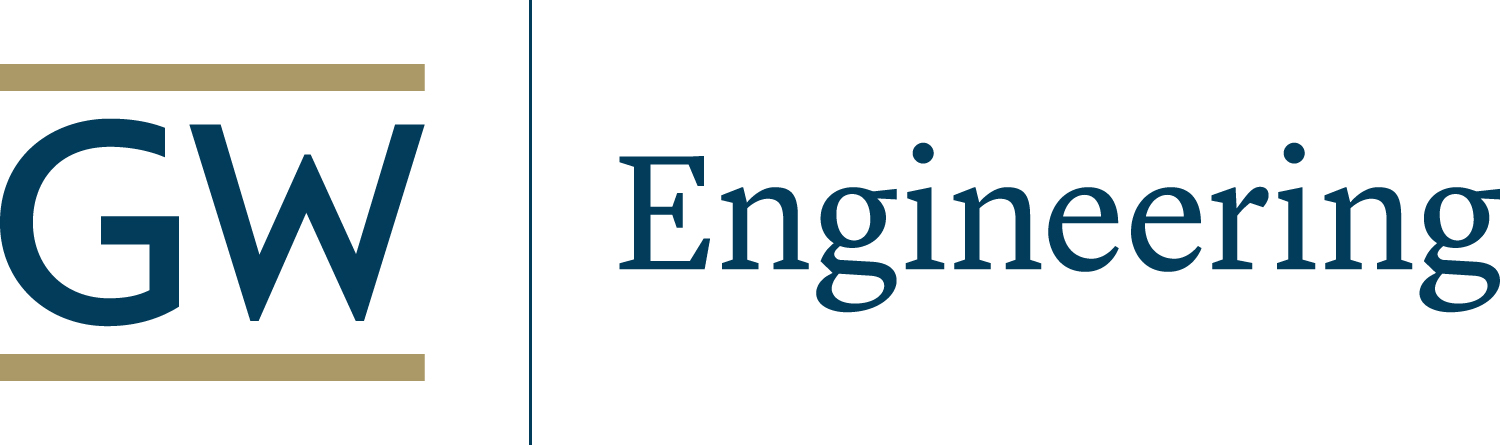

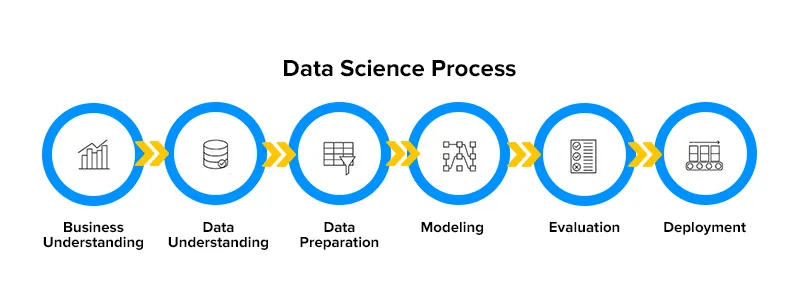

https://medium.com/@zuhailinasir_26370/data-science-process-ad8d1978377e

In [1]:
# !pip install shap

In [1]:
#Load the libraries - Load them all here - not sprinkled throughout the notebook.
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector as SFS
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
import shap
import warnings
warnings.filterwarnings('ignore') #ignore warnings

In [2]:
# Load the dataset (Using CSAT to highlight last weeks common issues)
df_csat = pd.read_csv('../data/cust_sat.csv')


In [3]:
#initial check of the data
df_csat.head(5)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5.0,4,3,4.0,4,5,5.0,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1.0,1,5,3.0,1,4,1.0,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5.0,4,3,4.0,4,4,5.0,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2.0,2,5,3.0,1,4,2.0,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3.0,3,4,4.0,3,3,3.0,0,0.0,satisfied


We can see that ultimately Unnamed: 0 and id will need to be dropped as these are not measurements or catagories.

### **DATA UNDERSTANDING**

In [4]:
df_csat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

We have caagorical variables to deal with - label encoding or one hot encoding.  Simple label encoding is fine.  This may change when we get to more complex features in datasets.

In [5]:
catagorical_vars = []
for col in df_csat.columns:
  if df_csat[col].dtype == 'object':
    catagorical_vars.append(col)
print(catagorical_vars)

['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']


In [6]:
l_encoder = LabelEncoder()
for col in catagorical_vars:
  df_csat[col] = l_encoder.fit_transform(df_csat[col])

In [7]:
df_csat.describe()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,...,103903.000000,103904.000000,103904.000000,103903.000000,103904.000000,103904.000000,103903.000000,103904.000000,103594.000000,103904.000000
mean,51951.500000,64924.210502,0.492541,0.182678,39.379706,0.310373,0.594135,1189.448375,2.729683,3.060296,...,3.358142,3.382363,3.351055,3.631830,3.304290,3.640428,3.286354,14.815618,15.178678,0.433333
std,29994.645522,37463.812252,0.499947,0.386404,15.114964,0.462649,0.620799,997.147281,1.327829,1.525075,...,1.332987,1.288354,1.315605,1.180909,1.265396,1.175663,1.312279,38.230901,38.698682,0.495538
min,0.000000,1.000000,0.000000,0.000000,7.000000,0.000000,0.000000,31.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25975.750000,32533.750000,0.000000,0.000000,27.000000,0.000000,0.000000,414.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,51951.500000,64856.500000,0.000000,0.000000,40.000000,0.000000,1.000000,843.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000
75%,77927.250000,97368.250000,1.000000,0.000000,51.000000,1.000000,1.000000,1743.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000
max,103903.000000,129880.000000,1.000000,1.000000,85.000000,1.000000,2.000000,4983.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000,1.000000


In [8]:
df_csat.isna().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 1
On-board service                       0
Leg room service                       0
Baggage handling                       1
Checkin service                        0
Inflight service                       0
Cleanliness                            1
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

We have some missing data to deal with.  Inspect data and make a decision on how to best deal with it.  Drop, impute (mean, ffill, etc)

I will focus on arrial delay as it has the most missing data.  Looking at the mean and standard deviation, I would not impute a mean.  The variation is too high comapred to the mean.  FFill or BFill does not make sense as there is no real sequence to this data.  Therefore instead of jus dropping, I am going to impute with a median.

You should always have a reason you can articulate for the actions you are taking in data analysis.

In [9]:
df_csat['Arrival Delay in Minutes'].fillna(df_csat['Arrival Delay in Minutes'].median(), inplace=True)

In [10]:
df_csat.dropna(inplace=True)

In [11]:
df_csat.isna().sum()

Unnamed: 0                           0
id                                   0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

Looks clean we can proceed.

Kurtosis: 0.2687787148603862
Skew: 1.1095293324691584


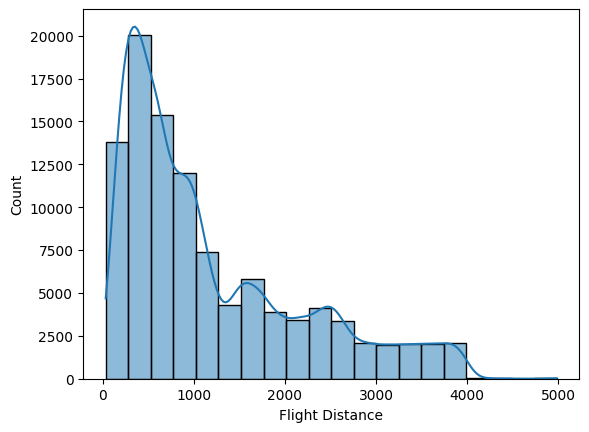

In [12]:
sns.histplot(df_csat['Flight Distance'], kde=True, bins = 20)

kurt = df_csat['Flight Distance'].kurtosis()
skew = df_csat['Flight Distance'].skew()
print("Kurtosis:", kurt)
print("Skew:", skew)


Kurtosis: 100.26446587203904
Skew: 6.733888868379083


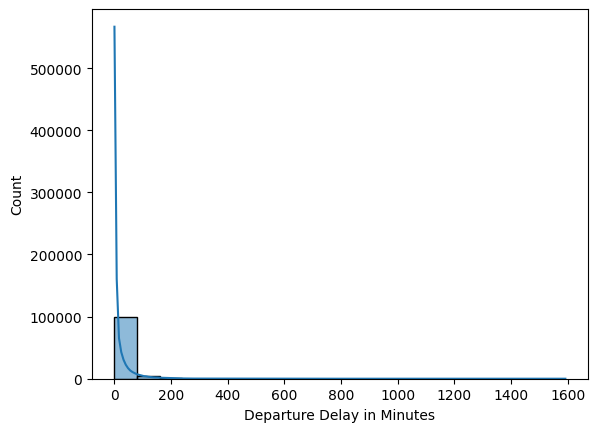

In [13]:
sns.histplot(df_csat['Departure Delay in Minutes'], kde=True, bins=20)

kurt = df_csat['Departure Delay in Minutes'].kurtosis()
skew = df_csat['Departure Delay in Minutes'].skew()
print("Kurtosis:", kurt)
print("Skew:", skew)


Kurtosis: 94.76788723350876
Skew: 6.6052040484555965


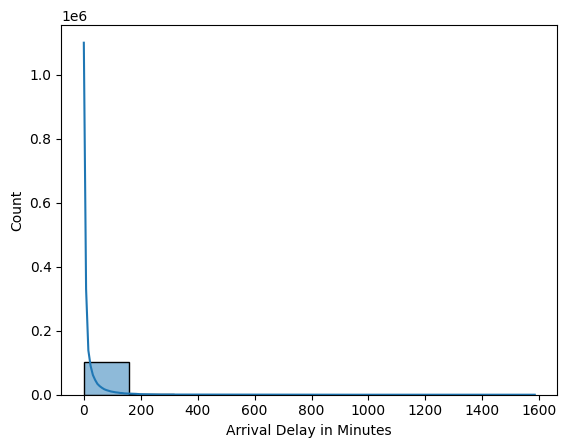

In [14]:
sns.histplot(df_csat['Arrival Delay in Minutes'], kde=True, bins=10)

kurt = df_csat['Arrival Delay in Minutes'].kurtosis()
skew = df_csat['Arrival Delay in Minutes'].skew()
print("Kurtosis:", kurt)
print("Skew:", skew)

These ratings will have an interesting distrution since this looks almost uniform or linearly increasing so we will treat as non-parametric and leave as is for now.

Kurtosis: -1.0377842892400695
Skew: -0.33437672957129905


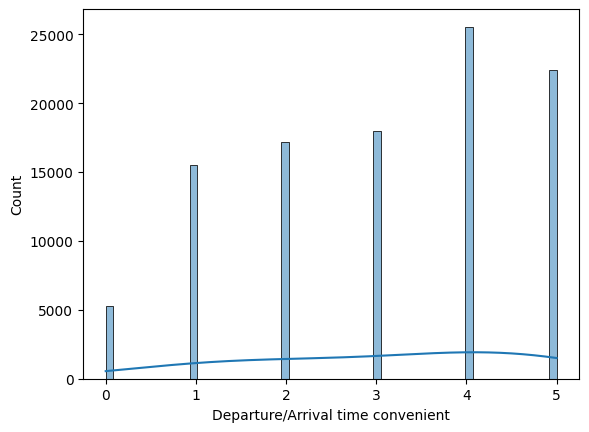

In [15]:
sns.histplot(df_csat['Departure/Arrival time convenient'], kde=True, kde_kws={'bw_adjust': 5})

kurt = df_csat['Departure/Arrival time convenient'].kurtosis()
skew = df_csat['Departure/Arrival time convenient'].skew()
print("Kurtosis:", kurt)
print("Skew:", skew)




These data that are not catagorical appear non-normal.  This reinforces that we are probably looking at a non-parametric dataseet and should use methods and models that use this approach.

In [13]:
csat_corr = df_csat.corr()

<Axes: >

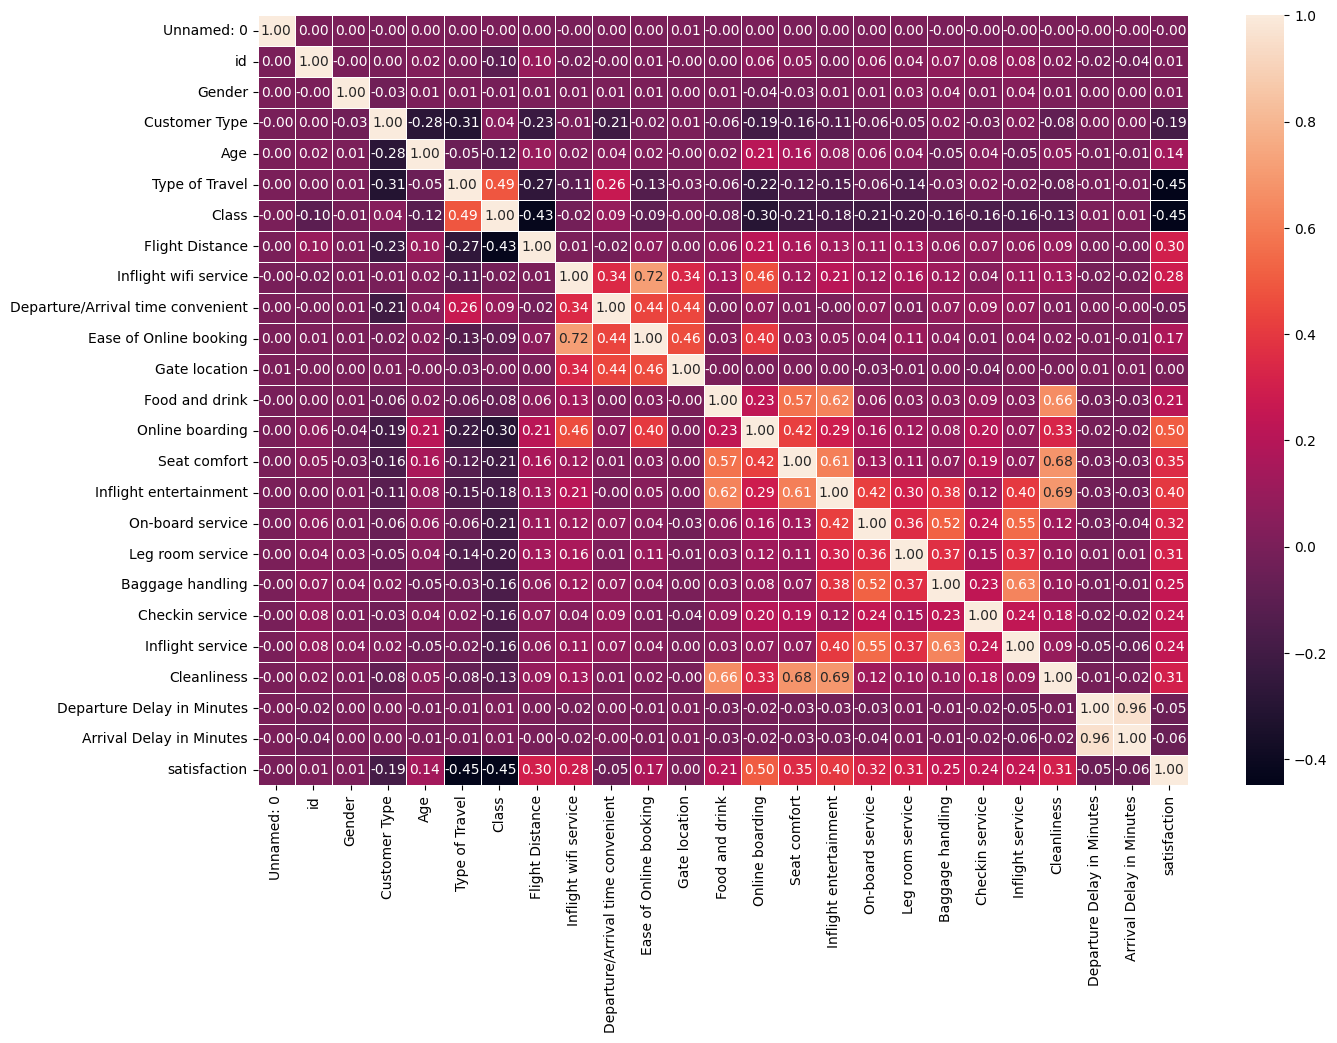

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(csat_corr, annot=True, linewidths=.5, ax=ax, fmt='.2f')

This clearly shows a high correlation between arrival and depature delay. We would likely benefit from dropping one of these.  Make sure you can clearly see your correlation values by adjusting the figure size and fmt parameters.


Lets check the imbalance of the data according to our target or dependent variance, 'satisfaction'

satisfaction
0    58878
1    45023
Name: count, dtype: int64


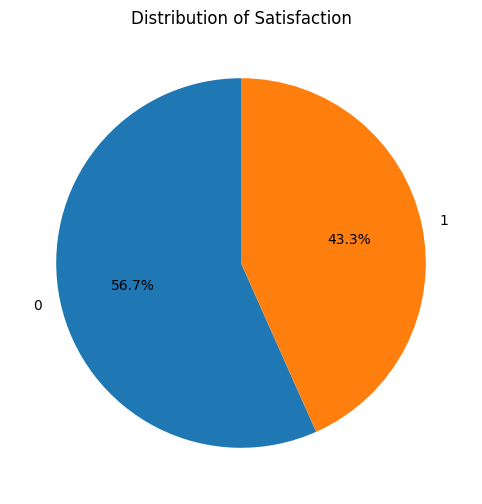

In [17]:
satisfaction_counts = df_csat['satisfaction'].value_counts()
print(satisfaction_counts)
plt.figure(figsize=(8, 6))
plt.pie(satisfaction_counts, labels=satisfaction_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Satisfaction')
plt.show()


This looks pretty balanced, so if we have the option of stratification when it comes to our test train split.

Now lets identify outliers to see if we might have candidates for removal or if we should account for these large outliers in our normalization or standardization operations.

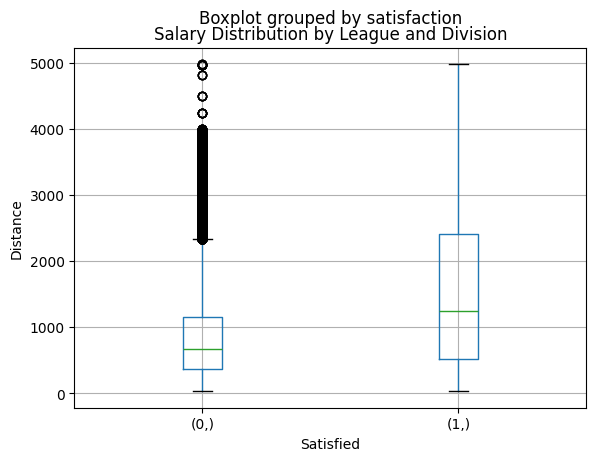

In [18]:
# @title Flight Distance by Satisfaction

import matplotlib.pyplot as plt

df_csat.boxplot(column='Flight Distance', by=['satisfaction'])
plt.xlabel('Satisfied')
plt.ylabel('Distance')
_ = plt.title('Salary Distribution by League and Division')

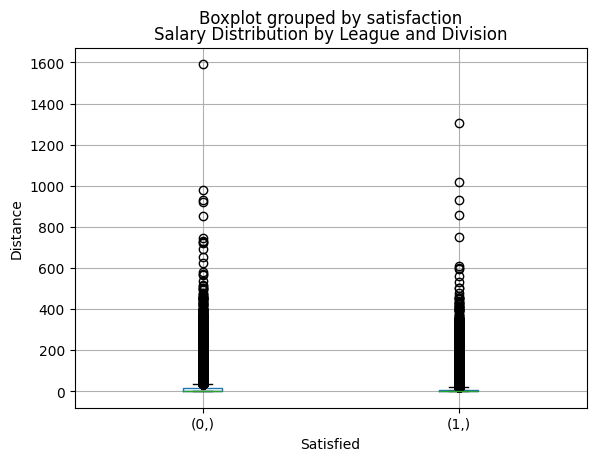

In [19]:
# @title Departure Delay by Satisfaction

import matplotlib.pyplot as plt

df_csat.boxplot(column='Departure Delay in Minutes', by=['satisfaction'])
plt.xlabel('Satisfied')
plt.ylabel('Distance')
_ = plt.title('Salary Distribution by League and Division')

To many outiers to thow away.  This goes to the nature of the data's non-normality.  If we still felt outliers should be removed, we may want to normalize the data in a way that does not leak information into a test set.

Kurtosis: -0.7103130820971297
Skew: -0.20393264014372384


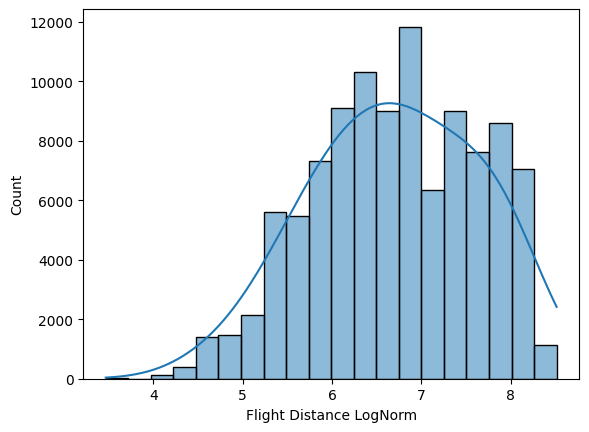

In [20]:
# prompt: log normalize flight distance
df_csat['Flight Distance LogNorm'] = np.log1p(df_csat['Flight Distance'])

sns.histplot(df_csat['Flight Distance LogNorm'], kde=True, bins = 20, kde_kws={'bw_adjust': 5})
kurt = df_csat['Flight Distance LogNorm'].kurtosis()
skew = df_csat['Flight Distance LogNorm'].skew()
print("Kurtosis:", kurt)
print("Skew:", skew)


Kurtosis: -0.5572316630560916
Skew: 0.9165587596310698


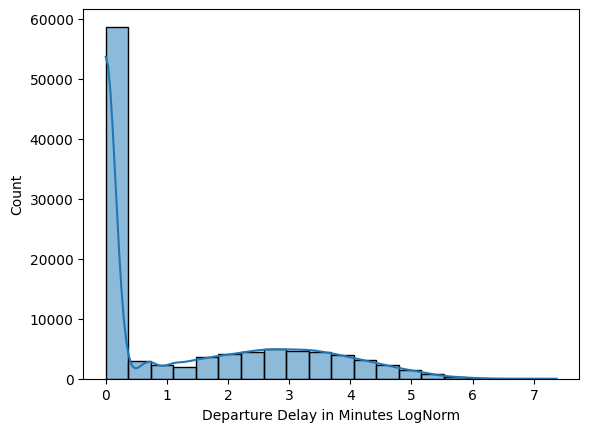

In [21]:
# prompt: log normalize Departure Delay in Minutes
df_csat['Departure Delay in Minutes LogNorm'] = np.log1p(df_csat['Departure Delay in Minutes'])

sns.histplot(df_csat['Departure Delay in Minutes LogNorm'], kde=True, bins = 20)
kurt = df_csat['Departure Delay in Minutes LogNorm'].kurtosis()
skew = df_csat['Departure Delay in Minutes LogNorm'].skew()
print("Kurtosis:", kurt)
print("Skew:", skew)

Kurtosis: -0.5572316630560916
Skew: 0.9165587596310698


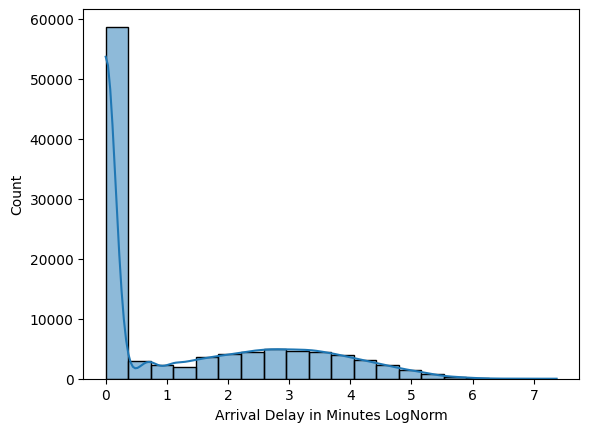

In [22]:
# prompt: log normalize Arrival Delay in Minutes
df_csat['Arrival Delay in Minutes LogNorm'] = np.log1p(df_csat['Departure Delay in Minutes'])

sns.histplot(df_csat['Arrival Delay in Minutes LogNorm'], kde=True, bins = 20)
kurt = df_csat['Arrival Delay in Minutes LogNorm'].kurtosis()
skew = df_csat['Arrival Delay in Minutes LogNorm'].skew()
print("Kurtosis:", kurt)
print("Skew:", skew)

When skewness and kurtosis are close to zero, it's considered a normal distribution.  This is not really clearly better than raw, so lets bypass this for now but very likely we could use these in an iteration.

So, what did we learn?  Data is non-parametric.  Many outliers, so hard to identify which to remove.  Probably good to drop 'Arrival Delay' as its highly correlated with departure.

### **DATA PREPARATION**

Dropping the columns or features that we identifed in understanding the data

In [23]:
df_csat.drop(['Unnamed: 0', 'id', 'Arrival Delay in Minutes', 'Arrival Delay in Minutes LogNorm', 'Departure Delay in Minutes LogNorm', 'Flight Distance LogNorm'], axis=1, inplace=True)


Seperate the X and y.

In [25]:
X = df_csat.drop('satisfaction', axis=1)
y = df_csat['satisfaction']


In [26]:
# X = sm.add_constant(X) # Will need this back if we use StatsModels


Splitting the data into test and train.  We are not creating a validation set, as that will be handled as a subset of the training set and created dynamically by the cross-validation libraries

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


We will leave all features in for now and cover feature selection in the iteration section; however, we will scale our data.  As the data had a large number of outliers, we will use standardization.

Data is prepped now we move to the training of the model.

### **MODELING**

Lets compare our classification methods to date.  Logistic Regression and Support Vector Machines

In [27]:
models = ['lr', 'svm', 'knn'] # will use this in a bit.

In [28]:
lr_pipeline = Pipeline([
    ('lt_scaler', StandardScaler()),  # Scaling step
    ('lr', LogisticRegression())  # Support Vector Machine model
])

svm_pipeline = Pipeline([
    ('svm_scaler', StandardScaler()),  # Scaling step
    ('svm', SVC())  # Support Vector Machine model
])

knn_pipeline = Pipeline([
    ('knn_scaler', StandardScaler()),  # Scaling step
    ('knn', KNeighborsClassifier())  # Support Vector Machine model
])

Here we will setup some Dictionaries of Lists as grids we will use to optimize models.

In [29]:
lr_param_grid = {
    'lr__C': [0.01, 0.1, 1, 10, 100]
}

In [31]:
svm_param_grid = {
    'svm__C': [.001],
    'svm__kernel': ['poly'],
    'svm__degree': [2]
}

In [32]:
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7],              # Number of neighbors (k)
    # 'weights': ['uniform', 'distance'],      # How neighbors contribute: equally or weighted by distance
    'knn__metric': ['euclidean', 'manhattan']
}

In [45]:
# grid_search_svm = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, verbose=2)

# # Fit the model with grid search
# grid_search_svm.fit(X_train, y_train)

# print("SVM Best parameters:", grid_search_svm.best_params_)
# print("SVM Best cross-validation score:", grid_search_svm.best_score_)

In [46]:
grid_search_lr = GridSearchCV(lr_pipeline, lr_param_grid, cv=5, verbose=2)

# Fit the model with grid search
grid_search_lr.fit(X_train, y_train)

print("LR Best parameters:", grid_search_lr.best_params_)
print("LR Best cross-validation score:", grid_search_lr.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[CV] END .........................................lr__C=0.01; total time=   0.1s
[CV] END .........................................lr__C=0.01; total time=   0.1s
[CV] END .........................................lr__C=0.01; total time=   0.1s
[CV] END .........................................lr__C=0.01; total time=   0.0s
[CV] END .........................................lr__C=0.01; total time=   0.0s
[CV] END ..........................................lr__C=0.1; total time=   0.0s
[CV] END ..........................................lr__C=0.1; total time=   0.0s
[CV] END ..........................................lr__C=0.1; total time=   0.0s
[CV] END ..........................................lr__C=0.1; total time=   0.0s
[CV] END ..........................................lr__C=0.1; total time=   0.0s
[CV] END ............................................lr__C=1; total time=   0.0s
[CV] END ............................................lr__C=1; total time=   0.0s
[CV] END ...................

In [53]:
grid_search_knn = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, verbose=2)

# Fit the model with grid search
grid_search_knn.fit(X_train, y_train)

print("KNN Best parameters:", grid_search_knn.best_params_)
print("KNN Best cross-validation score:", grid_search_knn.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ..........knn__metric=euclidean, knn__n_neighbors=3; total time=   5.8s
[CV] END ..........knn__metric=euclidean, knn__n_neighbors=3; total time=   1.6s
[CV] END ..........knn__metric=euclidean, knn__n_neighbors=3; total time=   1.9s
[CV] END ..........knn__metric=euclidean, knn__n_neighbors=3; total time=   1.7s
[CV] END ..........knn__metric=euclidean, knn__n_neighbors=3; total time=   1.6s
[CV] END ..........knn__metric=euclidean, knn__n_neighbors=5; total time=   1.6s
[CV] END ..........knn__metric=euclidean, knn__n_neighbors=5; total time=   1.7s
[CV] END ..........knn__metric=euclidean, knn__n_neighbors=5; total time=   1.6s
[CV] END ..........knn__metric=euclidean, knn__n_neighbors=5; total time=   1.6s
[CV] END ..........knn__metric=euclidean, knn__n_neighbors=5; total time=   1.6s
[CV] END ..........knn__metric=euclidean, knn__n_neighbors=7; total time=   1.8s
[CV] END ..........knn__metric=euclidean, knn__n_

In [34]:
grid_search_lr.best_params_

{'lr__C': 0.01}

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [34]:
# lr_best_model = grid_search_lr.best_estimator_
lr_best_model = LogisticRegression(C=.01)
lr_best_model.fit(X_train_scaled, y_train)


LogisticRegression(C=0.01)

In [ ]:
# svm_best_model = SVC(C=0.001, kernel='poly', probability=True)
# svm_best_model.fit(X_train_scaled, y_train)

In [42]:
knn_best_model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_best_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='euclidean')

In [ ]:
# grid_search_svm = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, verbose=1)
# # Fit the model with grid search
# grid_search_svm.fit(X_train, y_train)

Further Cross-Validation (if desired): If you want an additional layer of validation, you could perform cross-validation on the final model (after selecting the best parameters) on the same training data. This is not always necessary but can be done to further assess stability.

In [36]:
lr_train_results = cross_validate(lr_best_model, X_train_scaled, y_train, cv=5,
                         scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                         return_train_score=False)

lr_train_results

{'fit_time': array([0.08578014, 0.06851101, 0.07389235, 0.07536983, 0.06467986]),
 'score_time': array([0.01705885, 0.01057005, 0.01503921, 0.01859951, 0.01259995]),
 'test_accuracy': array([0.8787897 , 0.87463908, 0.87427815, 0.87903032, 0.87481954]),
 'test_precision': array([0.87485549, 0.87110338, 0.87025775, 0.87108761, 0.8771904 ]),
 'test_recall': array([0.84048313, 0.8340969 , 0.83425875, 0.84605775, 0.82690172]),
 'test_f1': array([0.85732493, 0.85219858, 0.8518781 , 0.85839025, 0.85130404]),
 'test_roc_auc': array([0.92923022, 0.92425901, 0.92584538, 0.92756741, 0.92710826])}

In [37]:
lr_avg_accuracy = lr_train_results['test_accuracy'].mean()
lr_avg_precision = lr_train_results['test_precision'].mean()
lr_avg_recall = lr_train_results['test_recall'].mean()
lr_avg_f1 = lr_train_results['test_f1'].mean()
lr_avg_roc_auc = lr_train_results['test_roc_auc'].mean()

print("X-V Average Train Accuracy:", lr_avg_accuracy)
print("X-V Average Train Precision:", lr_avg_precision)
print("X-V Average Train Recall:", lr_avg_recall)
print("X-V Average Train F1 Score:", lr_avg_f1)
print("X-V Average Train ROC AUC:", lr_avg_roc_auc)

y_pred = lr_best_model.predict(X_test_scaled)
y_pred_train = lr_best_model.predict(X_train_scaled)

lr_test_accuracy = accuracy_score(y_test, y_pred)
lr_test_precision = precision_score(y_test, y_pred)
lr_test_recall = recall_score(y_test, y_pred)
lr_test_f1 = f1_score(y_test, y_pred)
lr_test_roc_auc = roc_auc_score(y_test, y_pred)

print("Test Accuracy:", lr_test_accuracy)
print("Test Precision:", lr_test_precision)
print("Test Recall:", lr_test_recall)
print("Test F1 Score:", lr_test_f1)
print("Test ROC AUC:", lr_test_roc_auc)

X-V Average Train Accuracy: 0.8763113570741098
X-V Average Train Precision: 0.8728989249059017
X-V Average Train Recall: 0.8363596496400915
X-V Average Train F1 Score: 0.8542191809050766
X-V Average Train ROC AUC: 0.926802057319031
Test Accuracy: 0.8723353062893989
Test Precision: 0.8689591078066915
Test Recall: 0.8306496390893948
Test F1 Score: 0.8493726224947482
Test ROC AUC: 0.867430797805567


In [43]:
knn_train_results = cross_validate(knn_best_model, X_train_scaled, y_train, cv=5,
                         scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                         return_train_score=False)



NameError: name 'kn_train_results' is not defined

In [44]:
knn_train_results

{'fit_time': array([0.01999116, 0.02007079, 0.02202678, 0.02910948, 0.02087593]),
 'score_time': array([8.53800464, 3.98097444, 3.2411623 , 3.22174644, 3.26701498]),
 'test_accuracy': array([0.92931906, 0.92492782, 0.92643167, 0.92721367, 0.9269129 ]),
 'test_precision': array([0.9497165 , 0.94540015, 0.94788078, 0.94731343, 0.94996243]),
 'test_recall': array([0.88365959, 0.87741219, 0.8785397 , 0.88103831, 0.87756802]),
 'test_f1': array([0.91549802, 0.91013825, 0.91189396, 0.91297468, 0.91233134]),
 'test_roc_auc': array([0.96882292, 0.96802558, 0.96753312, 0.96790017, 0.96761524])}

In [45]:
knn_avg_accuracy = knn_train_results['test_accuracy'].mean()
knn_avg_precision = knn_train_results['test_precision'].mean()
knn_avg_recall = knn_train_results['test_recall'].mean()
knn_avg_f1 = knn_train_results['test_f1'].mean()
knn_avg_roc_auc = knn_train_results['test_roc_auc'].mean()

print("X-V Average Train Accuracy:", knn_avg_accuracy)
print("X-V Average Train Precision:", knn_avg_precision)
print("X-V Average Train Recall:", knn_avg_recall)
print("X-V Average Train F1 Score:", knn_avg_f1)
print("X-V Average Train ROC AUC:", knn_avg_roc_auc)

y_pred = knn_best_model.predict(X_test_scaled)
y_pred_train = knn_best_model.predict(X_train_scaled)

knn_test_accuracy = accuracy_score(y_test, y_pred)
knn_test_precision = precision_score(y_test, y_pred)
knn_test_recall = recall_score(y_test, y_pred)
knn_test_f1 = f1_score(y_test, y_pred)
knn_test_roc_auc = roc_auc_score(y_test, y_pred)

print("Test Accuracy:", knn_test_accuracy)
print("Test Precision:", knn_test_precision)
print("Test Recall:", knn_test_recall)
print("Test F1 Score:", knn_test_f1)
print("Test ROC AUC:", knn_test_roc_auc)

X-V Average Train Accuracy: 0.9269610202117422
X-V Average Train Precision: 0.9480546608009097
X-V Average Train Recall: 0.8796435611264755
X-V Average Train F1 Score: 0.9125672494981096
X-V Average Train ROC AUC: 0.9679794060303857
Test Accuracy: 0.9280111640440787
Test Precision: 0.95185942953424
Test Recall: 0.8782898389783453
Test F1 Score: 0.9135959339263025
Test ROC AUC: 0.9221612238369988


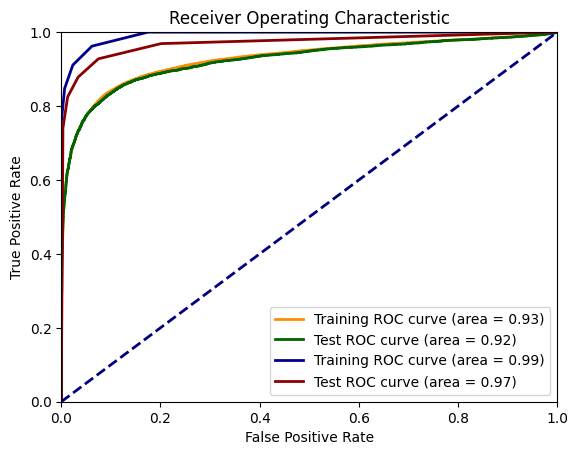

In [ ]:
lr_best_y_train_pred_prob = lr_best_model.predict_proba(X_train_scaled)[:, 1]
fpr_lr_train, tpr_lr_train, thresholds_lr_train = roc_curve(y_train, lr_best_y_train_pred_prob)
roc_auc_lr_train = auc(fpr_lr_train, tpr_lr_train)

lr_best_y_test_pred_prob = lr_best_model.predict_proba(X_test_scaled)[:, 1]
fpr_lr_test, tpr_lr_test, thresholds_lr_test = roc_curve(y_test, lr_best_y_test_pred_prob)
roc_auc_lr_test = auc(fpr_lr_test, tpr_lr_test)

knn_best_y_train_pred_prob = knn_best_model.predict_proba(X_train_scaled)[:, 1]
fpr_knn_train, tpr_knn_train, thresholds_knn_train = roc_curve(y_train, knn_best_y_train_pred_prob)
roc_auc_knn_train = auc(fpr_knn_train, tpr_knn_train)

knn_best_y_test_pred_prob = knn_best_model.predict_proba(X_test_scaled)[:, 1]
fpr_knn_test, tpr_knn_test, thresholds_knn_test = roc_curve(y_test, knn_best_y_test_pred_prob)
roc_auc_knn_test = auc(fpr_knn_test, tpr_knn_test)

plt.figure()
plt.plot(fpr_lr_train, tpr_lr_train, color='darkorange', lw=2, label='LR Training ROC curve (area = %0.2f)' % roc_auc_lr_train)
plt.plot(fpr_lr_test, tpr_lr_test, color='darkgreen', lw=2, label='LR Test ROC curve (area = %0.2f)' % roc_auc_lr_test)

plt.plot(fpr_knn_train, tpr_knn_train, color='darkblue', lw=2, label='KNN Training ROC curve (area = %0.2f)' % roc_auc_knn_train)
plt.plot(fpr_knn_test, tpr_knn_test, color='darkred', lw=2, label='KNN Test ROC curve (area = %0.2f)' % roc_auc_knn_test)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [38]:
conf_matrix_train = confusion_matrix(y_train, y_pred_train, labels=[True, False])

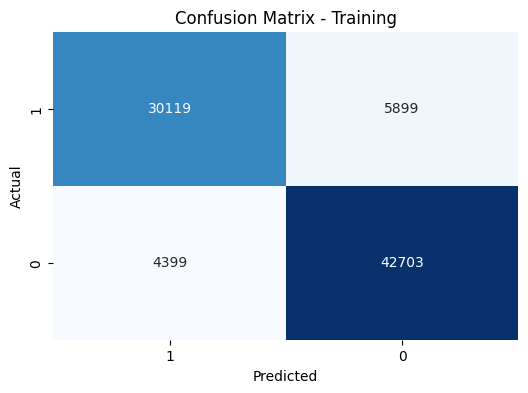

In [39]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['1', '0'],
            yticklabels=['1', '0'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Training')
plt.show()

In [40]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[True, False])

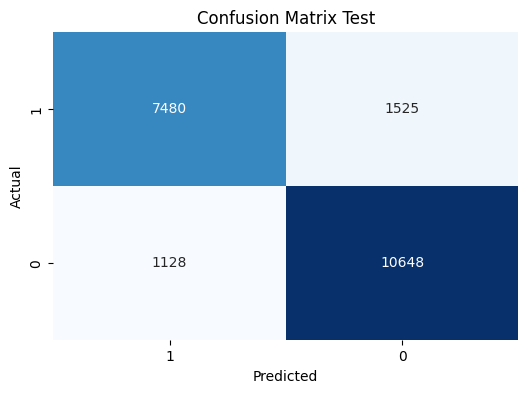

In [41]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['1', '0'],
            yticklabels=['1', '0'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Test')
plt.show()

In [ ]:
svm_train_results = cross_validate(svm_best_model, X_train_scaled, y_train, cv=5,
                         scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                         return_train_score=False)

svm_train_results

{'fit_time': array([539.95023465, 570.48637271, 630.79522681, 586.73706675,
        630.80025315]),
 'score_time': array([20.7686491 , 20.45632458, 22.19760036, 23.20169115, 20.68170595]),
 'test_accuracy': array([0.88053417, 0.87566169, 0.87620308, 0.88059432, 0.875     ]),
 'test_precision': array([0.88388521, 0.87965701, 0.88118519, 0.8797846 , 0.88391252]),
 'test_recall': array([0.83381924, 0.8260447 , 0.82565242, 0.83911716, 0.81912826]),
 'test_f1': array([0.85812259, 0.85200831, 0.85251541, 0.8589698 , 0.85028818]),
 'test_roc_auc': array([0.93004511, 0.92481003, 0.92605958, 0.9279036 , 0.92760853])}

In [ ]:
svm_avg_accuracy = svm_train_results['test_accuracy'].mean()
svm_avg_precision = svm_train_results['test_precision'].mean()
svm_avg_recall = svm_train_results['test_recall'].mean()
svm_avg_f1 = svm_train_results['test_f1'].mean()
svm_avg_roc_auc = svm_train_results['test_roc_auc'].mean()

print("X-V Average Train Accuracy:", svm_avg_accuracy)
print("X-V Average Train Precision:", svm_avg_precision)
print("X-V Average Train Recall:", svm_avg_recall)
print("X-V Average Train F1 Score:", svm_avg_f1)
print("X-V Average Train ROC AUC:", svm_avg_roc_auc)

y_pred = svm_best_model.predict(X_test_scaled)
y_pred_train = svm_best_model.predict(X_train_scaled)

svm_test_accuracy = accuracy_score(y_test, y_pred)
svm_test_precision = precision_score(y_test, y_pred)
svm_test_recall = recall_score(y_test, y_pred)
svm_test_f1 = f1_score(y_test, y_pred)
svm_test_roc_auc = roc_auc_score(y_test, y_pred)

print("Test Accuracy:", svm_test_accuracy)
print("Test Precision:", svm_test_precision)
print("Test Recall:", svm_test_recall)
print("Test F1 Score:", svm_test_f1)
print("Test ROC AUC:", svm_test_roc_auc)


X-V Average Train Accuracy: 0.8775986525505293
X-V Average Train Precision: 0.8816849054009476
X-V Average Train Recall: 0.82875235602292
X-V Average Train F1 Score: 0.8543808582113719
X-V Average Train ROC AUC: 0.9272853699285186
Test Accuracy: 0.8747413502718829
Test Precision: 0.8782793665800047
Test Recall: 0.8253192670738478
Test F1 Score: 0.8509761264098014
Test ROC AUC: 0.868926617232576


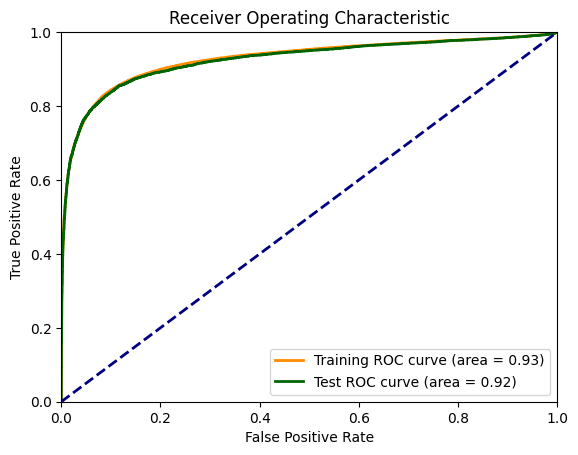

In [ ]:
svm_best_y_train_pred_prob = svm_best_model.predict_proba(X_train_scaled)[:, 1]
fpr_svm_train, tpr_svm_train, thresholds_svm_train = roc_curve(y_train, svm_best_y_train_pred_prob)
roc_auc_svm_train = auc(fpr_svm_train, tpr_svm_train)

svm_best_y_test_pred_prob = svm_best_model.predict_proba(X_test_scaled)[:, 1]
fpr_svm_test, tpr_svm_test, thresholds_svm_test = roc_curve(y_test, svm_best_y_test_pred_prob)
roc_auc_svm_test = auc(fpr_svm_test, tpr_svm_test)

plt.figure()
plt.plot(fpr_svm_train, tpr_svm_train, color='darkorange', lw=2, label='Training ROC curve (area = %0.2f)' % roc_auc_svm_train)
plt.plot(fpr_svm_test, tpr_svm_test, color='darkgreen', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_svm_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### **ITERATE**



SHAP

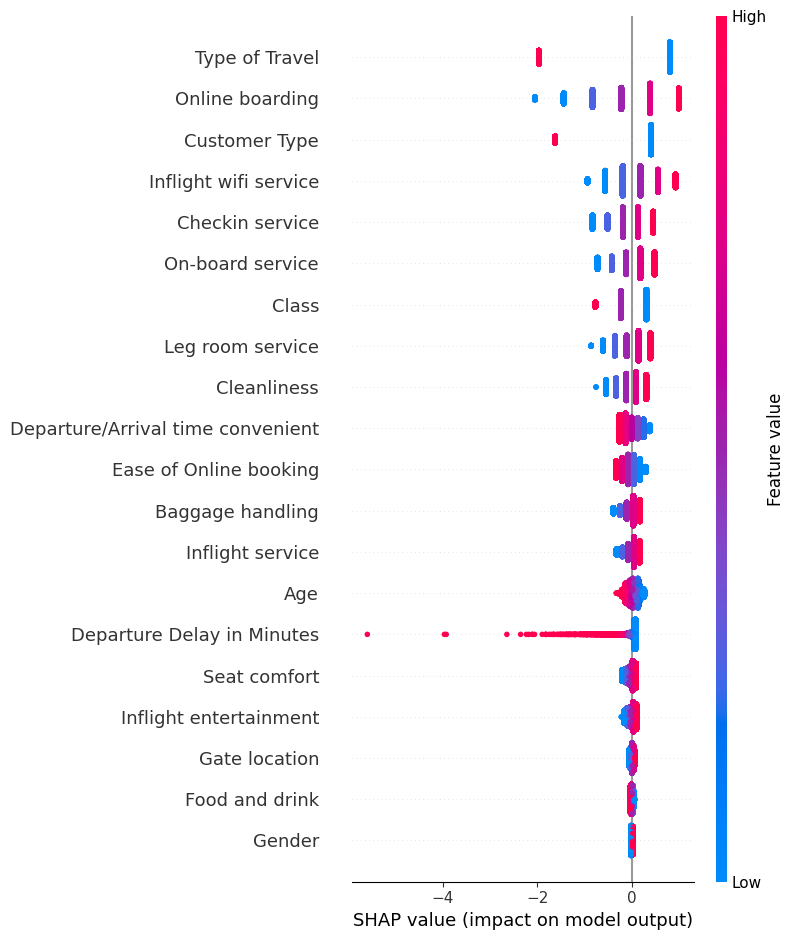

In [ ]:
feature_names = X.columns

explainer = shap.Explainer(lr_best_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

# Plot SHAP values
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)

In [ ]:
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame for easy handling
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean Absolute SHAP Value': mean_abs_shap_values
})

# Sort features by mean absolute SHAP values in descending order
top_features = feature_importance_df.sort_values(by='Mean Absolute SHAP Value', ascending=False)

print(top_features)

                              Feature  Mean Absolute SHAP Value
3                      Type of Travel                  1.163027
11                    Online boarding                  0.696237
1                       Customer Type                  0.627047
6               Inflight wifi service                  0.425272
17                    Checkin service                  0.347131
14                   On-board service                  0.332208
4                               Class                  0.308912
15                   Leg room service                  0.285958
19                        Cleanliness                  0.240497
7   Departure/Arrival time convenient                  0.166586
8              Ease of Online booking                  0.152717
16                   Baggage handling                  0.132301
18                   Inflight service                  0.118907
2                                 Age                  0.096922
20         Departure Delay in Minutes   

In [ ]:
# Get the top 10 features
top_10_features = top_features.head(10)

# Convert to a Python list
top_10_features_list = top_10_features['Feature'].tolist()

print("Top 10 Features:", top_10_features_list)

Top 10 Features: ['Type of Travel', 'Online boarding', 'Customer Type', 'Inflight wifi service', 'Checkin service', 'On-board service', 'Class', 'Leg room service', 'Cleanliness', 'Departure/Arrival time convenient']


In [ ]:
X_train_shap = X_train_scaled[top_10_features_list]
X_test_shap = X_test_scaled[top_10_features_list]

In [ ]:
lr_best_model.fit(X_train_shap, y_train)

LogisticRegression(C=0.01)

In [ ]:
lr_train_results = cross_validate(lr_best_model, X_train_shap, y_train, cv=5,
                         scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                         return_train_score=False)

lr_avg_accuracy = lr_train_results['test_accuracy'].mean()
lr_avg_precision = lr_train_results['test_precision'].mean()
lr_avg_recall = lr_train_results['test_recall'].mean()
lr_avg_f1 = lr_train_results['test_f1'].mean()
lr_avg_roc_auc = lr_train_results['test_roc_auc'].mean()

print("X-V Average Train Accuracy:", lr_avg_accuracy)
print("X-V Average Train Precision:", lr_avg_precision)
print("X-V Average Train Recall:", lr_avg_recall)
print("X-V Average Train F1 Score:", lr_avg_f1)
print("X-V Average Train ROC AUC:", lr_avg_roc_auc)

y_pred = lr_best_model.predict(X_test_shap)
y_pred_train = lr_best_model.predict(X_train_shap)

lr_test_accuracy = accuracy_score(y_test, y_pred)
lr_test_precision = precision_score(y_test, y_pred)
lr_test_recall = recall_score(y_test, y_pred)
lr_test_f1 = f1_score(y_test, y_pred)
lr_test_roc_auc = roc_auc_score(y_test, y_pred)

print("Test Accuracy:", lr_test_accuracy)
print("Test Precision:", lr_test_precision)
print("Test Recall:", lr_test_recall)
print("Test F1 Score:", lr_test_f1)
print("Test ROC AUC:", lr_test_roc_auc)

X-V Average Train Accuracy: 0.8725336862367662
X-V Average Train Precision: 0.8673551995973957
X-V Average Train Recall: 0.8332777816449018
X-V Average Train F1 Score: 0.8499648664851369
X-V Average Train ROC AUC: 0.925740478211431
Test Accuracy: 0.8695924161493672
Test Precision: 0.8634106916060501
Test Recall: 0.8304275402554137
Test F1 Score: 0.8465979848296162
Test ROC AUC: 0.8649844902364024


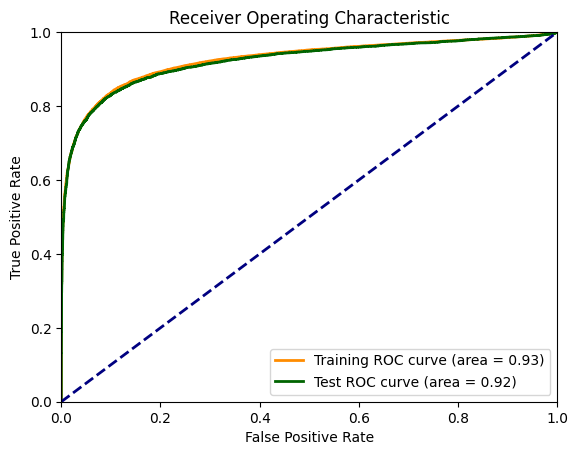

In [ ]:
lr_best_y_train_pred_prob = lr_best_model.predict_proba(X_train_shap)[:, 1]
fpr_lr_train, tpr_lr_train, thresholds_lr_train = roc_curve(y_train, lr_best_y_train_pred_prob)
roc_auc_lr_train = auc(fpr_lr_train, tpr_lr_train)

lr_best_y_test_pred_prob = lr_best_model.predict_proba(X_test_shap)[:, 1]
fpr_lr_test, tpr_lr_test, thresholds_lr_test = roc_curve(y_test, lr_best_y_test_pred_prob)
roc_auc_lr_test = auc(fpr_lr_test, tpr_lr_test)

plt.figure()
plt.plot(fpr_lr_train, tpr_lr_train, color='darkorange', lw=2, label='Training ROC curve (area = %0.2f)' % roc_auc_lr_train)
plt.plot(fpr_lr_test, tpr_lr_test, color='darkgreen', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_lr_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

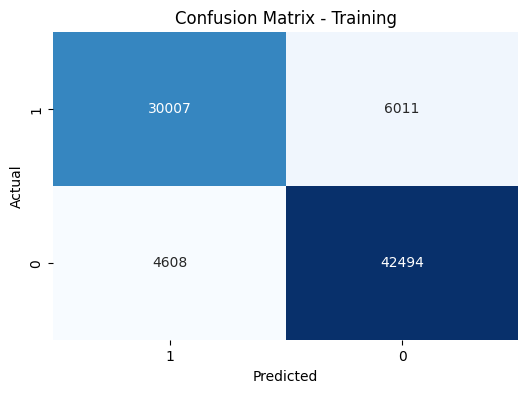

In [ ]:
conf_matrix_train = confusion_matrix(y_train, y_pred_train, labels=[True, False])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['1', '0'],
            yticklabels=['1', '0'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Training')
plt.show()

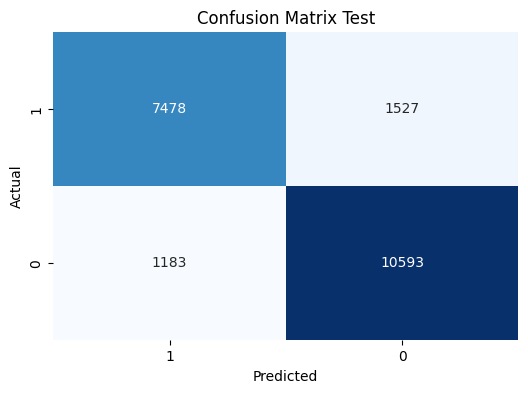

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[True, False])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['1', '0'],
            yticklabels=['1', '0'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Test')
plt.show()

PCA

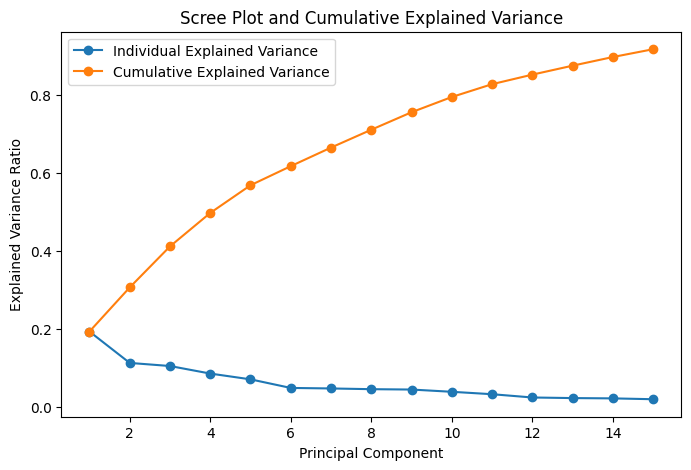

In [ ]:
# Apply PCA
pca = PCA(n_components=15)  # Reduce the data to 10 principal components

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Create a DataFrame with the PCA results
# Define the number of principal components
num_components = 15  # Adjust this if you have more/less components

# Create column names dynamically
component_names = [f'Principal Component {i+1}' for i in range(num_components)]

# Create DataFrames for PCA results
pca_df_train = pd.DataFrame(data=X_train_pca, columns=component_names)
pca_df_test = pd.DataFrame(data=X_test_pca, columns=component_names)


explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label='Cumulative Explained Variance')
plt.title('Scree Plot and Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.show()

In [ ]:
pca = PCA(n_components=11)  # Reduce the data to 3 principal components

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Create a DataFrame with the PCA results
# Define the number of principal components
num_components = 11  # Adjust this if you have more/less components

# Create column names dynamically
component_names = [f'Principal Component {i+1}' for i in range(num_components)]

# Create DataFrames for PCA results
pca_df_train = pd.DataFrame(data=X_train_pca, columns=component_names)
pca_df_test = pd.DataFrame(data=X_test_pca, columns=component_names)


explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Explained Variance Ratios:", explained_variance)
print("Cumulative Explained Variance:", cumulative_variance)


Explained Variance Ratios: [0.19339141 0.11299369 0.10507686 0.08572068 0.0709419  0.04891432
 0.04758319 0.04574104 0.04479948 0.03904014 0.03284571]
Cumulative Explained Variance: [0.19339141 0.3063851  0.41146196 0.49718265 0.56812454 0.61703886
 0.66462205 0.71036308 0.75516256 0.79420271 0.82704841]


In [ ]:
lr_best_model.fit(X_train_pca, y_train)

lr_train_results = cross_validate(lr_best_model, X_train_pca, y_train, cv=5,
                         scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                         return_train_score=False)

lr_avg_accuracy = lr_train_results['test_accuracy'].mean()
lr_avg_precision = lr_train_results['test_precision'].mean()
lr_avg_recall = lr_train_results['test_recall'].mean()
lr_avg_f1 = lr_train_results['test_f1'].mean()
lr_avg_roc_auc = lr_train_results['test_roc_auc'].mean()

print("X-V Average Train Accuracy:", lr_avg_accuracy)
print("X-V Average Train Precision:", lr_avg_precision)
print("X-V Average Train Recall:", lr_avg_recall)
print("X-V Average Train F1 Score:", lr_avg_f1)
print("X-V Average Train ROC AUC:", lr_avg_roc_auc)

y_pred = lr_best_model.predict(X_test_pca)
y_pred_train = lr_best_model.predict(X_train_pca)

lr_test_accuracy = accuracy_score(y_test, y_pred)
lr_test_precision = precision_score(y_test, y_pred)
lr_test_recall = recall_score(y_test, y_pred)
lr_test_f1 = f1_score(y_test, y_pred)
lr_test_roc_auc = roc_auc_score(y_test, y_pred)

print("Test Accuracy:", lr_test_accuracy)
print("Test Precision:", lr_test_precision)
print("Test Recall:", lr_test_recall)
print("Test F1 Score:", lr_test_f1)
print("Test ROC AUC:", lr_test_roc_auc)


X-V Average Train Accuracy: 0.8501804619826757
X-V Average Train Precision: 0.8417775332898005
X-V Average Train Recall: 0.8057083262318286
X-V Average Train F1 Score: 0.8233432262216424
X-V Average Train ROC AUC: 0.9102706050392321
Test Accuracy: 0.8489485587796545
Test Precision: 0.8431211979410388
Test Recall: 0.8003331482509717
Test F1 Score: 0.8211701703412523
Test ROC AUC: 0.8432287344515728


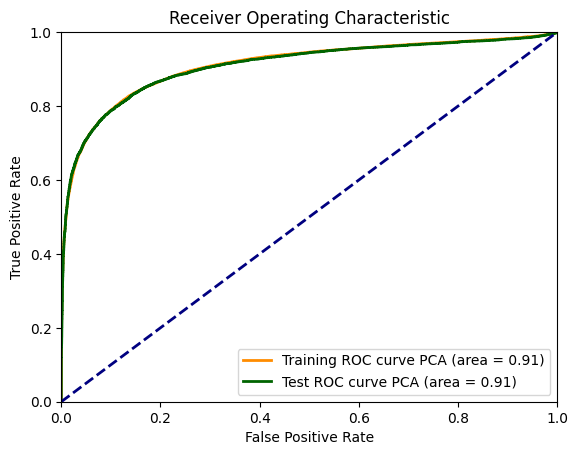

In [ ]:
lr_best_y_train_pred_prob = lr_best_model.predict_proba(X_train_pca)[:, 1]
fpr_lr_train, tpr_lr_train, thresholds_lr_train = roc_curve(y_train, lr_best_y_train_pred_prob)
roc_auc_lr_train = auc(fpr_lr_train, tpr_lr_train)

lr_best_y_test_pred_prob = lr_best_model.predict_proba(X_test_pca)[:, 1]
fpr_lr_test, tpr_lr_test, thresholds_lr_test = roc_curve(y_test, lr_best_y_test_pred_prob)
roc_auc_lr_test = auc(fpr_lr_test, tpr_lr_test)

plt.figure()
plt.plot(fpr_lr_train, tpr_lr_train, color='darkorange', lw=2, label='Training ROC curve PCA (area = %0.2f)' % roc_auc_lr_train)
plt.plot(fpr_lr_test, tpr_lr_test, color='darkgreen', lw=2, label='Test ROC curve PCA (area = %0.2f)' % roc_auc_lr_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

SFS

In [ ]:
sfs = SequentialFeatureSelector(lr_best_model, n_features_to_select='auto', direction='forward')
sfs.fit(X_train_scaled, y_train)


SequentialFeatureSelector(estimator=LogisticRegression(C=0.01))

In [ ]:
# Get the selected feature indices
selected_features = sfs.get_support(indices=True)

# Print the selected feature indices
print("Selected feature indices:", selected_features)

Selected feature indices: [ 1  3  6  7  9 11 13 14 17 19]


In [ ]:
X_train_selected = sfs.transform(X_train_scaled)
X_test_selected = sfs.transform(X_test_scaled)

In [ ]:
X_train_selected = pd.DataFrame(X_train_selected, columns=X.columns[selected_features])
X_test_selected = pd.DataFrame(X_test_selected, columns=X.columns[selected_features])

In [ ]:
X_train_selected

,Customer Type,Type of Travel,Inflight wifi service,Departure/Arrival time convenient,Gate location,Online boarding,Inflight entertainment,On-board service,Checkin service,Cleanliness
0,-0.473163,1.489325,0.202770,0.618000,1.581868,1.296216,-1.019391,-1.073821,0.547366,0.543112
1,2.113439,-0.671445,-0.550561,-0.693181,0.800002,-0.927657,-0.269758,-1.850062,-0.243489,-0.218662
2,-0.473163,-0.671445,1.709433,-0.693181,-0.763730,1.296216,1.229509,-1.073821,1.338221,1.304886
3,-0.473163,-0.671445,0.202770,-0.037591,0.018136,1.296216,1.229509,-0.297581,0.547366,1.304886
4,-0.473163,1.489325,-0.550561,0.618000,0.018136,-0.927657,0.479875,1.254900,1.338221,0.543112
...,...,...,...,...,...,...,...,...,...,...
83115,2.113439,-0.671445,0.202770,-0.037591,0.800002,-0.186366,-1.019391,-0.297581,-1.034343,-0.980435
83116,-0.473163,-0.671445,-1.303892,-1.348772,-1.545596,-0.927657,1.229509,1.254900,-1.825198,0.543112
83117,-0.473163,-0.671445,-1.303892,-1.348772,-1.545596,-0.186366,1.229509,1.254900,1.338221,0.543112
83118,2.113439,-0.671445,0.202770,-0.037591,0.018136,-0.186366,1.229509,0.478660,-1.034343,1.304886


In [ ]:
lr_best_model.fit(X_train_selected, y_train)

lr_train_results = cross_validate(lr_best_model, X_train_selected, y_train, cv=5,
                         scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                         return_train_score=False)

lr_avg_accuracy = lr_train_results['test_accuracy'].mean()
lr_avg_precision = lr_train_results['test_precision'].mean()
lr_avg_recall = lr_train_results['test_recall'].mean()
lr_avg_f1 = lr_train_results['test_f1'].mean()
lr_avg_roc_auc = lr_train_results['test_roc_auc'].mean()

print("X-V Average Train Accuracy:", lr_avg_accuracy)
print("X-V Average Train Precision:", lr_avg_precision)
print("X-V Average Train Recall:", lr_avg_recall)
print("X-V Average Train F1 Score:", lr_avg_f1)
print("X-V Average Train ROC AUC:", lr_avg_roc_auc)

y_pred = lr_best_model.predict(X_test_selected)
y_pred_train = lr_best_model.predict(X_train_selected)

lr_test_accuracy = accuracy_score(y_test, y_pred)
lr_test_precision = precision_score(y_test, y_pred)
lr_test_recall = recall_score(y_test, y_pred)
lr_test_f1 = f1_score(y_test, y_pred)
lr_test_roc_auc = roc_auc_score(y_test, y_pred)

print("Test Accuracy:", lr_test_accuracy)
print("Test Precision:", lr_test_precision)
print("Test Recall:", lr_test_recall)
print("Test F1 Score:", lr_test_f1)
print("Test ROC AUC:", lr_test_roc_auc)


X-V Average Train Accuracy: 0.8676612127045236
X-V Average Train Precision: 0.8602886545829586
X-V Average Train Recall: 0.8293076069621493
X-V Average Train F1 Score: 0.8444912424762933
X-V Average Train ROC AUC: 0.9223616775125111
Test Accuracy: 0.8625186468408642
Test Precision: 0.8551293900184843
Test Recall: 0.821987784564131
Test F1 Score: 0.8382311307400486
Test ROC AUC: 0.8577500064125003


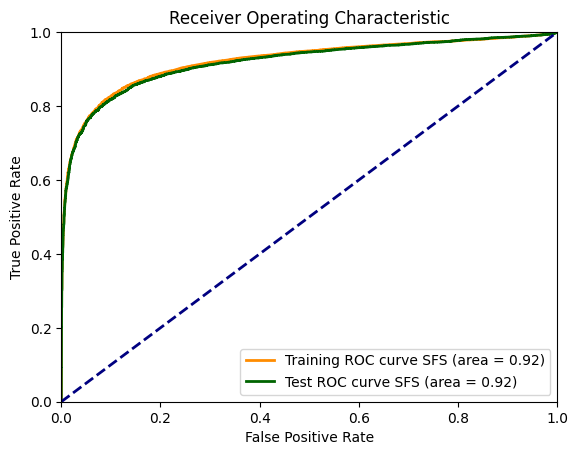

In [ ]:
lr_best_y_train_pred_prob = lr_best_model.predict_proba(X_train_selected)[:, 1]
fpr_lr_train, tpr_lr_train, thresholds_lr_train = roc_curve(y_train, lr_best_y_train_pred_prob)
roc_auc_lr_train = auc(fpr_lr_train, tpr_lr_train)

lr_best_y_test_pred_prob = lr_best_model.predict_proba(X_test_selected)[:, 1]
fpr_lr_test, tpr_lr_test, thresholds_lr_test = roc_curve(y_test, lr_best_y_test_pred_prob)
roc_auc_lr_test = auc(fpr_lr_test, tpr_lr_test)

plt.figure()
plt.plot(fpr_lr_train, tpr_lr_train, color='darkorange', lw=2, label='Training ROC curve SFS (area = %0.2f)' % roc_auc_lr_train)
plt.plot(fpr_lr_test, tpr_lr_test, color='darkgreen', lw=2, label='Test ROC curve SFS (area = %0.2f)' % roc_auc_lr_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()